<a href="https://colab.research.google.com/github/Bryan-PORTAILL/FCC-ML-Certification-Neural-Network-SMS-Text-Classifier./blob/main/FCC%20-%20ML%20Certification%20-%20Neural%20Network%20SMS%20Text%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my solution to the FreeCodeCamp Machine Learning Certification project Neural Network SMS Text Classifier.

I took the liberty of modifying a few things (such as some variable names) to make the project clearer to read.

The first cell imports all the utilities we will need to create a Long Short Term Memory Neural Network able to differentiate normal SMS messages from spam messages.

In [ ]:
# 1

import re
import nltk
import numpy
import pandas

from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

The second cell imports our data.

In [ ]:
# 2

!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

training_data = "train-data.tsv"
validation_data = "valid-data.tsv"

--2024-05-18 17:42:31--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2024-05-18 17:42:32 (9.74 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2024-05-18 17:42:32--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

The third cell turns our training and validation data into two dataframes. We also make copies of each dataframe to preserve the originals.

In [ ]:
# 3

training_dataframe = pandas.read_csv(
    training_data,
    sep = "\t",
    names = ['type', 'message'])

training_dataframe_for_processing = training_dataframe.copy()

validation_dataframe = pandas.read_csv(
    validation_data,
    sep = "\t",
    names = ['type', 'message'])

validation_dataframe_for_processing = validation_dataframe.copy()

*Below are samples and graphs of the two dataframes. Standard messages outnumber spam messages by a significant margin :*

In [ ]:
training_dataframe

,type,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


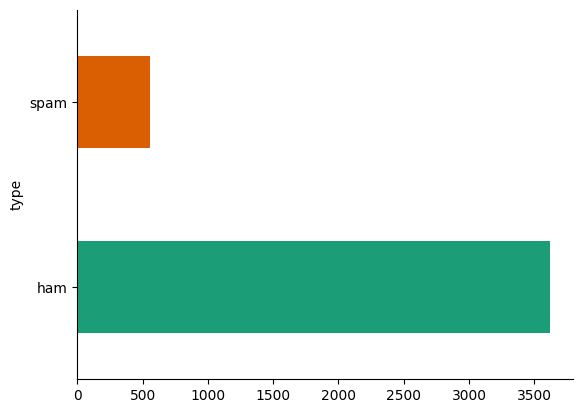

In [ ]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
training_dataframe.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
validation_dataframe

,type,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


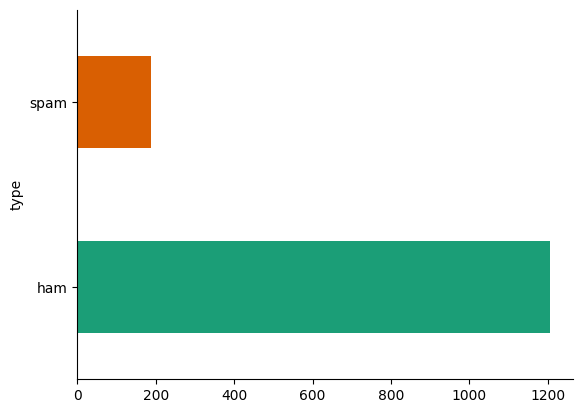

In [ ]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
validation_dataframe.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

We set up a few recurring variables in cell 4.

In [ ]:
# 4

maximum_processed_message_length = 250
number_of_most_frequently_used_words = 1000

Cell 5 is where we initialize the tokenizer, a tool that will store the n number of most frequently used words in the training data.

In [ ]:
# 5

tokenizer = Tokenizer(number_of_most_frequently_used_words)

Cell 6 is a small function that we'll use to clean the data of punctuation and normalize each word into its root form.

In [ ]:
# 6

def text_preprocessing(message):

  individual_words = []

  message_without_symbols = re.sub(r'([^\s\w])+', ' ', message)

  for word in message_without_symbols.split():
    individual_words.append(WordNetLemmatizer().lemmatize(word).lower())

  preprocessed_message = " ".join(individual_words)

  return preprocessed_message

We apply the function to our data in cell 7. We also convert the two types of messages (ham / spam) into numerical values (0 / 1).

In [ ]:
# 7

training_dataframe_for_processing['message'] = training_dataframe['message'].apply(text_preprocessing)
validation_dataframe_for_processing['message'] = validation_dataframe['message'].apply(text_preprocessing)

training_dataframe_for_processing['type'] = training_dataframe['type'].astype('category').cat.codes
validation_dataframe_for_processing['type'] = validation_dataframe['type'].astype('category').cat.codes

*Below are examples of what the text_preprocessing function does :*

In [ ]:
training_dataframe

,type,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [ ]:
training_dataframe_for_processing

,type,message
0,0,ahhhh just woken up had a bad dream about u th...
1,0,you can never do nothing
2,0,now u sound like manky scouse boy steve like i...
3,0,mum say we wan to go then go then she can shun...
4,0,never y lei i v lazy got wat dat day ü send me...
...,...,...
4174,0,just woke up yeesh it late but i didn t fall a...
4175,0,what do u reckon a need 2 arrange transport if...
4176,1,free entry into our 250 weekly competition jus...
4177,1,pls stop bootydelious 32 f is inviting you to ...


We calibrate the tokenizer in cell 8 and then use it on our data. We also pad each message to get sequences of the same length.

In [ ]:
# 8

tokenizer.fit_on_texts(training_dataframe_for_processing['message'])

encoded_training_messages = tokenizer.texts_to_sequences(training_dataframe_for_processing['message'])
processed_training_messages = sequence.pad_sequences(encoded_training_messages, maxlen=maximum_processed_message_length, padding='post')

encoded_validation_messages = tokenizer.texts_to_sequences(validation_dataframe_for_processing['message'])
processed_validation_messages = sequence.pad_sequences(encoded_validation_messages, maxlen=maximum_processed_message_length, padding='post')

*We can observe the result of the processing below :*

In [ ]:
training_dataframe_for_processing

,type,message
0,0,ahhhh just woken up had a bad dream about u th...
1,0,you can never do nothing
2,0,now u sound like manky scouse boy steve like i...
3,0,mum say we wan to go then go then she can shun...
4,0,never y lei i v lazy got wat dat day ü send me...
...,...,...
4174,0,just woke up yeesh it late but i didn t fall a...
4175,0,what do u reckon a need 2 arrange transport if...
4176,1,free entry into our 250 weekly competition jus...
4177,1,pls stop bootydelious 32 f is inviting you to ...


In [ ]:
processed_training_messages

array([[ 39,  48, 152, ...,   0,   0,   0],
       [  2,  25, 286, ...,   0,   0,   0],
       [ 21,   6, 410, ...,   0,   0,   0],
       ...,
       [ 50, 467, 348, ...,   0,   0,   0],
       [102,  90, 764, ...,   0,   0,   0],
       [100,  12, 409, ...,   0,   0,   0]], dtype=int32)

We then assign our processed data to specific variables for ease of use, in cell 9.

In [ ]:
# 9

training_data = processed_training_messages
training_labels = training_dataframe_for_processing['type']

validation_data = processed_validation_messages
validation_labels = validation_dataframe_for_processing['type']

And then in cell 10 we build our model.

In [ ]:
# 10

model = Sequential([
    Embedding(number_of_most_frequently_used_words, 64, input_length = maximum_processed_message_length, mask_zero=True),
    Dropout(0.5),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')])

model.compile(
    Adam(),
    BinaryCrossentropy(),
    ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           64000     
                                                                 
 dropout (Dropout)           (None, 250, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 162945 (636.50 KB)
Trainable params: 162945 (636.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


And we train it in cell 11.

In [ ]:
# 11

model.fit(
    training_data,
    training_labels,
    validation_data = (validation_data, validation_labels),
    batch_size = 500,
    epochs = 10)

Epoch 1/10
9/9 [==============================] - 48s 4s/step - loss: 0.6646 - accuracy: 0.7995 - val_loss: 0.5935 - val_accuracy: 0.8657
Epoch 2/10
9/9 [==============================] - 33s 4s/step - loss: 0.5288 - accuracy: 0.8658 - val_loss: 0.4585 - val_accuracy: 0.8657
Epoch 3/10
9/9 [==============================] - 38s 4s/step - loss: 0.4073 - accuracy: 0.8674 - val_loss: 0.3075 - val_accuracy: 0.8714
Epoch 4/10
9/9 [==============================] - 33s 4s/step - loss: 0.2504 - accuracy: 0.9158 - val_loss: 0.1588 - val_accuracy: 0.9555
Epoch 5/10
9/9 [==============================] - 34s 4s/step - loss: 0.1578 - accuracy: 0.9610 - val_loss: 0.1198 - val_accuracy: 0.9641
Epoch 6/10
9/9 [==============================] - 33s 4s/step - loss: 0.1167 - accuracy: 0.9739 - val_loss: 0.0970 - val_accuracy: 0.9756
Epoch 7/10
9/9 [==============================] - 35s 4s/step - loss: 0.0906 - accuracy: 0.9809 - val_loss: 0.0739 - val_accuracy: 0.9777
Epoch 8/10
9/9 [==================

Cell 12 is the function we'll use to test the model.

In [ ]:
# 12

def predict_message(pred_text):

  preprocessed_message = pandas.Series([pred_text]).apply(text_preprocessing)
  encoded_message = tokenizer.texts_to_sequences(preprocessed_message)
  processed_message = sequence.pad_sequences(encoded_message, maxlen = maximum_processed_message_length)

  ham_or_spam = model.predict(processed_message)
  result = numpy.squeeze(ham_or_spam[0])

  return (float(result), 'ham' if ham_or_spam[0] < 0.5 else 'spam')

*Two  examples of the predict_message function output :*

In [ ]:
pred_text = "how are you doing today"
prediction = predict_message(pred_text)
print('message :', pred_text,'- prediction :', prediction)

1/1 [==============================] - 0s 358ms/step
message : how are you doing today - prediction : (0.0018314142944291234, 'ham')


In [ ]:
pred_text = "sale today! to stop texts call 98912460324"
prediction = predict_message(pred_text)
print('message :', pred_text,'- prediction :', prediction)

1/1 [==============================] - 0s 53ms/step
message : sale today! to stop texts call 98912460324 - prediction : (0.6725767850875854, 'spam')


Cell 13 is the test module provided by FreeCodeCamp.

In [ ]:
# 13

# Run this cell to test your function and model. Do not modify contents.

def test_predictions():

  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]

  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 57ms/step
You passed the challenge. Great job!
